# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [2]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Configurations

In [3]:
class DSB2018Config(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "DSB2018"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = DSB2018Config()
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  1024
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           DSB2018
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING  

## Notebook Preferences

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [5]:
class DSB2018Dataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_DSB2018(self, data_dir, set_name, config=None):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("DSB2018", 1, "nuclie")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        filenames = np.genfromtxt(set_name, dtype=str)
        for i in range(len(filenames)):
            self.add_image("DSB2018", image_id=i, path=None, channels=3, data_dir=data_dir, name=filenames[i])

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        data_dir = info['data_dir']
        name = info['name']
        channels = info['channels']
        
        imgs = os.listdir(os.path.join(data_dir, name, 'images'))
        img = plt.imread(os.path.join(data_dir, name, 'images', '%s' % (imgs[0])))
        img = img[:,:,:channels] * 256
        return img

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        data_dir = info['data_dir']
        name = info['name']
        mask_files = os.listdir(os.path.join(data_dir, name, 'masks'))
        masks = []
        for i in range(len(mask_files)):
            mask = plt.imread(os.path.join(data_dir, name, 'masks', '%s' % (mask_files[i])))
            masks.append(mask)
            
        class_ids = np.ones(len(masks))
        masks = np.array(masks)
        masks = np.moveaxis(masks, 0, -1)
        return masks, class_ids.astype(np.int32)

In [6]:
data_dir = '/home/htang6/data/dsb2018/stage1_train/'
# Training dataset
set_name = '/home/htang6/workspace/Mask_RCNN/filenames/filenames_train.csv'
dataset_train = DSB2018Dataset()
dataset_train.load_DSB2018(data_dir, set_name)
dataset_train.prepare()

# Validation dataset
set_name = '/home/htang6/workspace/Mask_RCNN/filenames/filenames_val.csv'
dataset_val = DSB2018Dataset()
dataset_val.load_DSB2018(data_dir, set_name)
dataset_val.prepare()

(256, 256, 3)
(256, 256, 6)
[1 1 1 1 1 1]


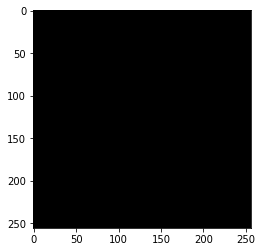

In [7]:
print(dataset_train.load_image(0).shape)
print(dataset_train.load_mask(0)[0].shape)
print(dataset_train.load_mask(0)[1])
plt.imshow(dataset_train.load_image(0))

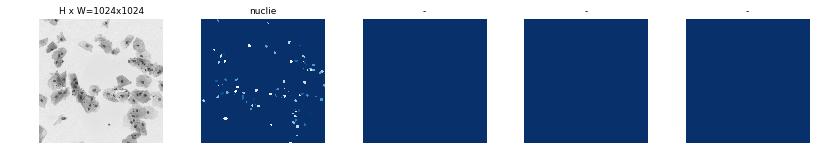

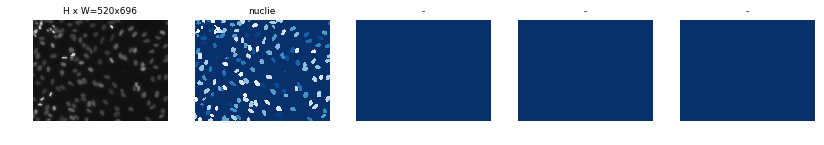

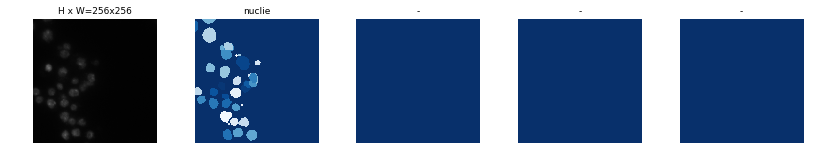

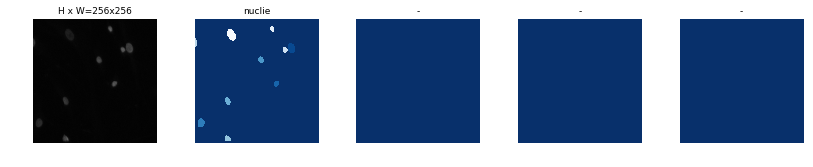

In [8]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
image_ids = [16, 31, 2, 3]
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Ceate Model

In [9]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [10]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [15]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 1. LR=0.001

Checkpoint Path: /mnt/data/htang6/workspace/Mask_RCNN/logs/dsb201820180221T2154/mask_rcnn_dsb2018_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistri

/home/htang6/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/htang6/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:2033: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=100, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: /mnt/data/htang6/workspace/Mask_RCNN/logs/dsb201820180221T2154/mask_rcnn_dsb2018_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (

/home/htang6/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/htang6/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:2033: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 2/100


/home/htang6/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/htang6/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


100/100 [==============================] - 46s 458ms/step - loss: 2.3536 - rpn_class_loss: 0.2361 - rpn_bbox_loss: 0.8868 - mrcnn_class_loss: 0.3265 - mrcnn_bbox_loss: 0.4612 - mrcnn_mask_loss: 0.4430 - val_loss: 1.2235 - val_rpn_class_loss: 0.0392 - val_rpn_bbox_loss: 0.3688 - val_mrcnn_class_loss: 0.2422 - val_mrcnn_bbox_loss: 0.2322 - val_mrcnn_mask_loss: 0.3410
Epoch 3/100
100/100 [==============================] - 34s 343ms/step - loss: 2.1489 - rpn_class_loss: 0.1988 - rpn_bbox_loss: 0.8679 - mrcnn_class_loss: 0.2581 - mrcnn_bbox_loss: 0.4147 - mrcnn_mask_loss: 0.4093 - val_loss: 0.8898 - val_rpn_class_loss: 0.0301 - val_rpn_bbox_loss: 0.3171 - val_mrcnn_class_loss: 0.0100 - val_mrcnn_bbox_loss: 0.2244 - val_mrcnn_mask_loss: 0.3083
Epoch 4/100
 77/100 [======================>.......] - ETA: 7s - loss: 2.2756 - rpn_class_loss: 0.1927 - rpn_bbox_loss: 0.9894 - mrcnn_class_loss: 0.2462 - mrcnn_bbox_loss: 0.4238 - mrcnn_mask_loss: 0.4236

In [10]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [11]:
class InferenceConfig(DSB2018Config):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /mnt/data/htang6/workspace/Mask_RCNN/logs/dsb201820180221T2250/mask_rcnn_dsb2018_0100.h5


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000
image_meta               shape: (10,)                 min:    0.00000  max: 1024.00000
gt_class_id              shape: (33,)                 min:    1.00000  max:    1.00000
gt_bbox                  shape: (33, 4)               min:    0.00000  max: 1024.00000
gt_mask                  shape: (1024, 1024, 33)      min:    0.00000  max:    1.00000


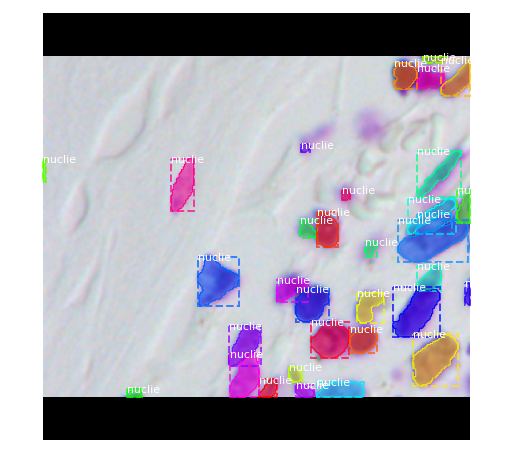

In [21]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

# image_id = 16
# original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
#     modellib.load_image_gt(dataset_train, inference_config, 
#                            image_id, use_mini_mask=False)
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (256, 320, 3)         min:   18.07059  max:  241.94510
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000
image_metas              shape: (1, 10)               min:    0.00000  max: 1024.00000


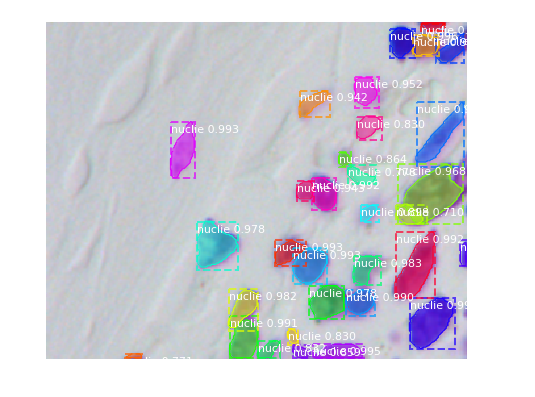

In [22]:
img = dataset_val.load_image(image_id)
results = model.detect([img], verbose=1)

r = results[0]
visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [41]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

print(r['masks'].shape)
print(r['scores'])
masks = r['masks']
# whole = np.zeros(shape=masks.shape[:2])
# for i in range(masks.shape[-1]):
#     whole = np.logical_or(whole, masks[:,:,i])
    
# plt.imshow(whole)
reduced = []
for i in range(masks.shape[-1]):
    mask = np.copy(masks[:,:,i])
    for j in range(len(reduced)):
        intersection = mask & reduced[j]
        if np.any(intersection):
#             print('Overlap!!')
#             print(np.where(intersection))
            mask -= intersection
            
#             plt.imshow(intersection)
#             plt.show()
#             plt.imshow(mask)
#             plt.show()
#             plt.imshow(reduced[j])
#             plt.show()
            
    if np.any(mask):
        reduced.append(mask)
        
rles = []
test_ids = []
for m in reduced:
    rles.append(rle_encoding(m))
test_ids.extend(['test'] * len(reduced))

import pandas as pd
sub = pd.DataFrame()
sub['ImageId'] = test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-1.csv', index=False)
print(sub)

(256, 320, 32)
[0.9971697  0.99582964 0.9945339  0.99331784 0.99328107 0.9927954
 0.9921508  0.9920859  0.9911851  0.99046665 0.9874351  0.9834874
 0.9815144  0.9805147  0.9783029  0.978157   0.9683178  0.95240587
 0.9431202  0.94237137 0.9397261  0.9273334  0.8978374  0.86357665
 0.858545   0.831884   0.82994    0.82985514 0.7778135  0.77081865
 0.7599422  0.710297  ]
   ImageId                                      EncodedPixels
0     test  71141 7 71394 18 71649 20 71904 22 72159 24 72...
1     test  67337 10 67592 16 67847 18 68102 20 68357 22 6...
2     test  52479 1 52734 2 52989 3 53245 3 53500 4 53755 ...
3     test  48568 8 48822 12 49076 15 49330 18 49585 21 49...
4     test  44976 8 45231 10 45485 12 45740 13 45995 14 46...
5     test  24424 9 24675 19 24928 23 25182 25 25436 27 25...
6     test  52347 15 52600 19 52855 21 53111 22 53367 23 5...
7     test  68294 11 68548 14 68803 15 69057 17 69312 18 6...
8     test  36086 8 36340 11 36594 14 36847 17 37097 23 37...
9     te

## Evaluation

In [11]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

ValueError: cannot reshape array of size 0 into shape (0)